In [1]:
# --------------------- IMPORT NECESSARY LIBRARIES ---------------------
from fastai.vision.all import *
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.patches import Patch

# --------------------- DEFINE REQUIRED VARIABLES ---------------------

# Define your data root path
dataroot_path = Path('/home/exsdatalab/data/surgvu24')

# Load the images DataFrame
images_df = pd.read_csv(dataroot_path / 'final_labels.csv')

# Get all model paths with '.pkl' extension in 'models/baseline/' directory
models_path = [pth for pth in Path('models/baseline/').ls() if pth.suffix == '.pkl']

# Check if models are found
if not models_path:
    raise ValueError("No models found in 'models/baseline/' directory with '.pkl' extension.")

print(f"Found {len(models_path)} models for ensemble.")

# --------------------- DEFINE REQUIRED FUNCTIONS ---------------------

def get_image(r): 
    """
    Constructs the full image path for a given row in the DataFrame.
    
    Args:
        r (pd.Series): A row from the DataFrame.
    
    Returns:
        str: Full path to the image file.
    """
    return str(dataroot_path / 'frames' / f"{r['filename']}.jpg")

def get_label(r): 
    """
    Retrieves the task label from a given row in the DataFrame.
    
    Args:
        r (pd.Series): A row from the DataFrame.
    
    Returns:
        str: The task label.
    """
    return r['task_label']

def extract_video_part(filename: str) -> int:
    """
    Extracts the video part number from the filename.

    Example:
        'case_000_video_part_001_t8.333333_f000002' -> 1

    Args:
        filename (str): The filename string.

    Returns:
        int: Extracted video part number.
    """
    match = re.search(r'video_part_(\d+)', filename)
    if match:
        return int(match.group(1))
    else:
        raise ValueError(f"Cannot extract video_part from filename: {filename}")

def extract_timestamp(filename: str) -> float:
    """
    Extracts the timestamp from the filename.

    Example:
        'case_000_video_part_001_t8.333333_f000002' -> 8.333333

    Args:
        filename (str): The filename string.

    Returns:
        float: Extracted timestamp.
    """
    match = re.search(r'_t(\d+\.\d+)_f', filename)
    if match:
        return float(match.group(1))
    else:
        raise ValueError(f"Cannot extract timestamp from filename: {filename}")

def get_sorted_surgery_frames(df: pd.DataFrame, case_folder_name: str) -> pd.DataFrame:
    """
    Filters and sorts the DataFrame to get all frames from the specified surgery (case_folder),
    sorted first by video_part and then by timestamp.

    Args:
        df (pd.DataFrame): The DataFrame containing all frames.
        case_folder_name (str): The name of the surgery (case_folder) to filter.

    Returns:
        pd.DataFrame: The filtered and sorted DataFrame.
    """
    # Filter frames for the specified case_folder
    surgery_df = df[df['case_folder'] == case_folder_name].copy()

    # Extract 'video_part' and 'timestamp' from 'filename'
    surgery_df['video_part'] = surgery_df['filename'].apply(extract_video_part)
    surgery_df['parsed_timestamp'] = surgery_df['filename'].apply(extract_timestamp)

    # Sort by 'video_part' and then by 'parsed_timestamp'
    surgery_df.sort_values(by=['video_part', 'parsed_timestamp'], inplace=True)

    # Reset index
    surgery_df.reset_index(drop=True, inplace=True)

    return surgery_df

def smooth_predictions_with_neighbors(predicted_classes: List[str], window_size: int = 1) -> List[str]:
    """
    Smooths the predicted class labels by exploring the neighboring frames.

    Args:
        predicted_classes (List[str]): The list of predicted class labels per frame.
        window_size (int): Number of neighboring frames to consider on each side for smoothing.

    Returns:
        List[str]: The smoothed list of predicted class labels.
    """
    if not predicted_classes:
        return []

    num_frames = len(predicted_classes)
    smoothed_predictions = []

    for i in range(num_frames):
        # Define the window boundaries
        start_idx = max(0, i - window_size)
        end_idx = min(num_frames - 1, i + window_size)

        # Extract the neighborhood labels
        neighborhood = predicted_classes[start_idx:end_idx + 1]

        # Count the frequency of each label in the neighborhood
        label_counts = {}
        for label in neighborhood:
            label_counts[label] = label_counts.get(label, 0) + 1

        # Identify the most common label(s)
        max_count = max(label_counts.values())
        common_labels = [label for label, count in label_counts.items() if count == max_count]

        # Resolve ties by retaining the current frame's label
        if len(common_labels) == 1:
            most_common_label = common_labels[0]
        else:
            most_common_label = predicted_classes[i]

        smoothed_predictions.append(most_common_label)

    return smoothed_predictions

def ensemble_predict(models_path: List[Path], image_files: List[Path], cpu: bool = False) -> Tuple[torch.Tensor, List[str]]:
    """
    Perform ensemble predictions using multiple models from models_path.

    Args:
        models_path (List[Path]): Paths to the models.
        image_files (List[Path]): List of full image file paths for prediction.
        cpu (bool): Whether to run on CPU or not.

    Returns:
        Tuple[torch.Tensor, List[str]]: Averaged raw predictions and the vocabulary.
    """
    all_raw_preds = []
    vocab = None  # To store vocabulary from the first model

    for idx, model_path in enumerate(models_path):
        # Load the model
        try:
            learner = load_learner(model_path, cpu=cpu)
        except Exception as e:
            print(f"Error loading model at {model_path}: {e}")
            continue
        print(f'Loaded model {idx+1}/{len(models_path)} from {model_path}.')

        # Create test_dl using the loaded learner's DataLoaders with bs=128 and num_workers=8
        test_dl = learner.dls.test_dl(image_files, bs=128, num_workers=8)

        # Get predictions from the model
        try:
            with torch.no_grad():
                raw_preds, _ = learner.get_preds(dl=test_dl)
            all_raw_preds.append(raw_preds.cpu())
        except Exception as e:
            print(f"Error during prediction with model at {model_path}: {e}")
            continue

        # Store vocab from the first model
        if vocab is None:
            vocab = learner.dls.vocab

        # Free up memory
        del learner
        torch.cuda.empty_cache()

    if not all_raw_preds:
        raise ValueError("No predictions were made. Please check your models and image paths.")

    # Ensure all models have the same number of classes
    num_classes = all_raw_preds[0].shape[1]
    for idx, preds in enumerate(all_raw_preds[1:], start=2):
        if preds.shape[1] != num_classes:
            raise ValueError(f"Mismatch in number of classes across models. Model {idx} has {preds.shape[1]} classes, expected {num_classes}.")

    # Average the predictions across all models
    avg_raw_preds = torch.stack(all_raw_preds).mean(0)

    return avg_raw_preds, vocab

def decode_predictions(preds: torch.Tensor, vocab: List[str]) -> List[str]:
    """
    Convert raw predictions into class labels.

    Args:
        preds (torch.Tensor): Raw predictions (logits or probabilities).
        vocab (List[str]): List of class labels.

    Returns:
        List[str]: List of predicted class labels.
    """
    pred_indices = preds.argmax(dim=1)
    predicted_classes = [vocab[i] for i in pred_indices]
    return predicted_classes

def evaluate_window_sizes(true_labels: List[str], pred_labels: List[str], window_sizes: range, vocab: List[str]) -> Tuple[List[float], List[float]]:
    """
    Evaluate the F1 score for different window sizes, comparing before and after smoothing.

    Args:
        true_labels (List[str]): Ground truth labels.
        pred_labels (List[str]): Predicted labels before smoothing.
        window_sizes (range): Range of window sizes to test.
        vocab (List[str]): List of class labels.

    Returns:
        Tuple[List[float], List[float]]: F1 scores before and after smoothing.
    """
    f1_before = []
    f1_after = []

    # Map class labels to indices
    label_to_idx = {label: idx for idx, label in enumerate(vocab)}
    true_indices = [label_to_idx[label] for label in true_labels]
    pred_indices = [label_to_idx[label] for label in pred_labels]

    # Convert to tensors
    true_tensor = torch.tensor(true_indices)
    pred_tensor_before = torch.tensor(pred_indices)

    # Instantiate FastAI's F1Score with 'macro' average
    f1_metric = F1Score(average='macro')

    # Compute F1 score before smoothing
    f1_before_score = f1_metric(pred_tensor_before, true_tensor).item()

    for ws in window_sizes:
        # Apply smoothing with the current window size
        smoothed_pred_labels = smooth_predictions_with_neighbors(pred_labels, window_size=ws)
        smoothed_pred_indices = [label_to_idx[label] for label in smoothed_pred_labels]
        smoothed_pred_tensor = torch.tensor(smoothed_pred_indices)

        # Compute F1 score after smoothing
        f1_after_score = f1_metric(smoothed_pred_tensor, true_tensor).item()

        # Store the scores
        f1_before.append(f1_before_score)
        f1_after.append(f1_after_score)

        print(f'Window Size {ws}: F1 Before = {f1_before_score:.4f}, F1 After = {f1_after_score:.4f}')

    return f1_before, f1_after

def visualize_surgery_predictions(images_df: pd.DataFrame, models_path: List[Path], dataroot_path: Path, window_size: int = 15):
    """
    Randomly selects a surgery from the validation set and visualizes the predictions from each model,
    ensemble, and smoothed predictions, along with the ground truth.

    The visualization consists of a heatmap where each row represents:
    - Ground Truth
    - Each Model's Predictions
    - Ensemble Predictions
    - Smoothed Predictions

    Each column represents a frame, and the color corresponds to the task label.

    Args:
        images_df (pd.DataFrame): DataFrame containing image information.
        models_path (List[Path]): List of paths to the ensemble models (.pkl files).
        dataroot_path (Path): Path to the data root directory.
        window_size (int): Window size for prediction smoothing.

    Returns:
        None
    """
    # Get all unique surgeries from the validation set
    valid_surgeries = images_df[images_df['valid'] == True]['case_folder'].unique()

    if len(valid_surgeries) == 0:
        raise ValueError("No valid surgeries found in the validation set.")

    # Randomly select one surgery
    random_surgery = random.choice(valid_surgeries)
    print(f'\nSelected Surgery for Visualization: {random_surgery}')

    # Filter and sort frames
    try:
        surgery_frames_df = get_sorted_surgery_frames(images_df, random_surgery)
    except ValueError as ve:
        print(f"Error during filtering/sorting: {ve}")
        return

    num_frames = len(surgery_frames_df)
    print(f'Number of frames in {random_surgery}: {num_frames}')

    if num_frames == 0:
        print(f'No frames found for surgery {random_surgery}.')
        return

    # Construct full image paths
    image_files = [Path(get_image(r)) for _, r in surgery_frames_df.iterrows()]

    # Verify image existence
    missing_files = [str(img) for img in image_files if not img.exists()]
    if missing_files:
        print(f'Warning: {len(missing_files)} image files are missing for surgery {random_surgery}.')
        # Remove missing files
        image_files = [img for img in image_files if img.exists()]
        surgery_frames_df = surgery_frames_df[surgery_frames_df['filename'].isin([img.stem for img in image_files])]
        print(f'Reduced to {len(image_files)} existing image paths after removing missing files.')

    if not image_files:
        print(f'All image files missing for surgery {random_surgery}.')
        return

    # Get ground truth labels
    true_labels = surgery_frames_df['task_label'].tolist()

    # Define vocab (assuming all models have the same vocab)
    # Load the first model to get vocab
    first_model_path = models_path[0]
    try:
        first_learner = load_learner(first_model_path, cpu=False)
    except Exception as e:
        print(f"Error loading first model at {first_model_path}: {e}")
        return
    vocab = first_learner.dls.vocab
    del first_learner
    torch.cuda.empty_cache()

    # Define color mapping
    num_classes = len(vocab)
    cmap = plt.get_cmap('tab20')  # Up to 20 distinct colors
    if num_classes > 20:
        # If more classes, use a different colormap or extend tab20
        cmap = plt.get_cmap('hsv')
    colors = {label: cmap(i % cmap.N) for i, label in enumerate(vocab)}

    # Initialize a dictionary to hold predictions from each model
    model_predictions = {f'Model_{i+1}': [] for i in range(len(models_path))}

    # Perform predictions for each model
    for idx, model_path in enumerate(models_path):
        try:
            learner = load_learner(model_path, cpu=False)
        except Exception as e:
            print(f"Error loading model at {model_path}: {e}")
            # Fill with 'N/A' for missing predictions
            model_predictions[f'Model_{idx+1}'] = ['N/A'] * len(image_files)
            continue

        # Create test_dl with bs=128 and num_workers=8
        test_dl = learner.dls.test_dl(image_files, bs=128, num_workers=8)

        try:
            with torch.no_grad():
                raw_preds, _ = learner.get_preds(dl=test_dl)
            preds = decode_predictions(raw_preds.cpu(), vocab)
        except Exception as e:
            print(f"Error during prediction with model at {model_path}: {e}")
            preds = ['N/A'] * len(image_files)

        model_predictions[f'Model_{idx+1}'] = preds

        # Clean up
        del learner
        torch.cuda.empty_cache()

    # Perform ensemble prediction
    try:
        ensemble_preds, _ = ensemble_predict(models_path, image_files, cpu=False)
        ensemble_pred_labels = decode_predictions(ensemble_preds, vocab)
    except Exception as e:
        print(f"Error during ensemble prediction: {e}")
        ensemble_pred_labels = ['N/A'] * len(image_files)

    # Apply smoothing
    smoothed_pred_labels = smooth_predictions_with_neighbors(ensemble_pred_labels, window_size=window_size)

    # Prepare data for plotting
    # Rows: Ground Truth, Model1, Model2, ..., Ensemble, Smoothed
    # Labels: 'GT', model path names, 'Ensemble', 'Post Proc'
    rows = ['GT'] + [model_path.name for model_path in models_path] + ['Ensemble', 'Post Proc']
    data_rows = []

    # Ground Truth
    data_rows.append(true_labels)

    # Models
    for model_name in model_predictions:
        data_rows.append(model_predictions[model_name])

    # Ensemble
    data_rows.append(ensemble_pred_labels)

    # Smoothed
    data_rows.append(smoothed_pred_labels)

    # Convert labels to integers for plotting
    label_to_int = {label: idx for idx, label in enumerate(vocab)}
    data_matrix = []
    for row in data_rows:
        row_int = []
        for label in row:
            if label == 'N/A':
                # Assign a unique integer for missing predictions, e.g., -1
                row_int.append(-1)
            else:
                row_int.append(label_to_int.get(label, -1))
        data_matrix.append(row_int)

    data_matrix = np.array(data_matrix)

    # Define a new colormap that includes a color for missing predictions
    cmap_colors = [colors[label] for label in vocab]
    if -1 in data_matrix:
        cmap_colors.append('grey')  # Color for missing predictions
    cmap_with_missing = ListedColormap(cmap_colors)

    # Define bounds and norm
    bounds = list(range(len(vocab) + 1))  # +1 for missing
    norm = BoundaryNorm(bounds, cmap_with_missing.N)

    # Create the plot
    plt.figure(figsize=(20, len(rows)))  # Adjust height based on number of rows

    im = plt.imshow(data_matrix, aspect='auto', cmap=cmap_with_missing, norm=norm)

    # Set y-ticks
    plt.yticks(ticks=np.arange(len(rows)), labels=rows)

    # Set x-ticks (optional, can set to show every N frames if too many)
    if num_frames <= 50:
        plt.xticks(ticks=np.arange(num_frames), labels=np.arange(1, num_frames + 1), rotation=90)
    else:
        # Show ticks at intervals
        step = max(1, num_frames // 50)
        plt.xticks(ticks=np.arange(0, num_frames, step), labels=np.arange(1, num_frames + 1, step), rotation=90)

    # Create custom legend
    legend_elements = [Patch(facecolor=colors[label], edgecolor='k', label=label) for label in vocab]
    if -1 in data_matrix:
        legend_elements.append(Patch(facecolor='grey', edgecolor='k', label='N/A'))
    plt.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    plt.xlabel('Frame Number')
    plt.title(f'Prediction Visualization for {random_surgery}')
    plt.tight_layout()
    plt.show()

Found 3 models for ensemble.


In [ ]:
# --------------------- MAIN EXPERIMENTATION WORKFLOW ---------------------

# --------------------- STEP 1: SELECT ALL SURGERIES ---------------------

# Get all unique surgeries from the validation set
valid_surgeries = images_df[images_df['valid'] == True]['case_folder'].unique()
print(f'\nFound {len(valid_surgeries)} unique surgeries in the validation set.')

if len(valid_surgeries) == 0:
    raise ValueError("No valid surgeries found in the validation set.")

# Initialize a list to store results
results = []

# Initialize a dictionary to store improvements per window size
# Key: window_size, Value: list of improvements for each surgery
window_size_improvements = {ws: [] for ws in range(1, 21)}

# --------------------- STEP 2: PROCESS EACH SURGERY ---------------------

for surgery in valid_surgeries:
    print(f'\nProcessing Surgery: {surgery}')
    try:
        # Filter and sort frames from the selected surgery
        surgery_frames_df = get_sorted_surgery_frames(images_df, surgery)
        num_frames = len(surgery_frames_df)
        print(f'Number of frames in {surgery}: {num_frames}')
        
        if num_frames == 0:
            print(f'No frames found for surgery {surgery}. Skipping.')
            continue
        
        # Construct full image file paths using the provided get_image function
        image_files = [Path(get_image(r)) for _, r in surgery_frames_df.iterrows()]
        print(f'Constructed {len(image_files)} image paths.')
        
        # --------------------- VERIFY IMAGE FILES EXISTENCE (OPTIONAL) ---------------------
        
        # Optional: Verify that image files exist to prevent prediction errors
        missing_files = [str(img) for img in image_files if not img.exists()]
        if missing_files:
            print(f'Warning: {len(missing_files)} image files are missing for surgery {surgery}.')
            # Handle missing files as needed, e.g., remove from list
            # For simplicity, we'll remove missing files
            image_files = [img for img in image_files if img.exists()]
            surgery_frames_df = surgery_frames_df[surgery_frames_df['filename'].isin([img.stem for img in image_files])]
            print(f'Reduced to {len(image_files)} existing image paths after removing missing files.')
        
        if not image_files:
            print(f'All image files missing for surgery {surgery}. Skipping.')
            continue
        
        # --------------------- PERFORM ENSEMBLE PREDICTIONS ---------------------
        
        print("Starting ensemble predictions...")
        avg_raw_preds, vocab = ensemble_predict(models_path, image_files, cpu=False)
        print("Ensemble predictions completed.")
        
        # --------------------- DECODE PREDICTIONS ---------------------
        
        predicted_classes = decode_predictions(avg_raw_preds, vocab)
        print("Decoding predictions completed.")
        
        # --------------------- GET GROUND TRUTH LABELS ---------------------
        
        true_labels = surgery_frames_df['task_label'].tolist()
        print("Retrieved ground truth labels.")
        
        # --------------------- EVALUATE WINDOW SIZES ---------------------
        
        # Define the range of window sizes to test (1 to 20)
        window_sizes = range(1, 21)
        
        print("\nEvaluating window sizes for smoothing...\n")
        f1_before, f1_after = evaluate_window_sizes(true_labels, predicted_classes, window_sizes, vocab)
        
        # --------------------- CALCULATE IMPROVEMENTS ---------------------
        
        # Calculate improvement for each window size
        for ws, f1_a in zip(window_sizes, f1_after):
            improvement = f1_a - f1_before[0]
            window_size_improvements[ws].append(improvement)
        
        # --------------------- IDENTIFY THE OPTIMAL WINDOW SIZE FOR THIS SURGERY ---------------------
        
        # Find the window size with the highest F1 score after smoothing
        best_ws_index = np.argmax(f1_after)
        best_ws = window_sizes[best_ws_index]
        best_f1 = f1_after[best_ws_index]
        
        print(f'\nOptimal window size for {surgery}: {best_ws} with F1 score: {best_f1:.4f}')
        
        # Append the result to the list
        results.append({
            'surgery': surgery,
            'best_window_size': best_ws,
            'best_f1_score': best_f1
        })
        
    except Exception as e:
        print(f"An error occurred while processing surgery {surgery}: {e}")
        # Optionally, log the error and continue
        continue

# --------------------- STEP 3: AGGREGATE RESULTS ---------------------

if not results:
    raise ValueError("No results were recorded. Please check the data and models.")

# Convert results to DataFrame
results_df = pd.DataFrame(results)
print(f'\nProcessed {len(results_df)} surgeries successfully.')

# Display the first few results
print("\nSample Results:")
print(results_df.head())

# --------------------- STEP 4: ANALYZE OPTIMAL WINDOW SIZES ---------------------

# Statistical summaries
mean_ws = results_df['best_window_size'].mean()
median_ws = results_df['best_window_size'].median()
mode_ws = results_df['best_window_size'].mode()[0]
std_ws = results_df['best_window_size'].std()

print("\nStatistical Summary of Optimal Window Sizes:")
print(f"Mean Window Size: {mean_ws:.2f}")
print(f"Median Window Size: {median_ws}")
print(f"Mode Window Size: {mode_ws}")
print(f"Standard Deviation: {std_ws:.2f}")

# Frequency distribution
window_size_counts = results_df['best_window_size'].value_counts().sort_index()
print("\nDistribution of Optimal Window Sizes:")
print(window_size_counts)


Found 34 unique surgeries in the validation set.

Processing Surgery: case_002
Number of frames in case_002: 2437
Constructed 2437 image paths.
Starting ensemble predictions...
Loaded model 1/3 from models/baseline/regnety_008.pkl.


Loaded model 2/3 from models/baseline/convnextv2_tiny.pkl.


Loaded model 3/3 from models/baseline/vit_tiny.pkl.


Ensemble predictions completed.
Decoding predictions completed.
Retrieved ground truth labels.

Evaluating window sizes for smoothing...

Window Size 1: F1 Before = 0.5865, F1 After = 0.5826
Window Size 2: F1 Before = 0.5865, F1 After = 0.5775
Window Size 3: F1 Before = 0.5865, F1 After = 0.5795
Window Size 4: F1 Before = 0.5865, F1 After = 0.5818
Window Size 5: F1 Before = 0.5865, F1 After = 0.5818
Window Size 6: F1 Before = 0.5865, F1 After = 0.5838
Window Size 7: F1 Before = 0.5865, F1 After = 0.5843
Window Size 8: F1 Before = 0.5865, F1 After = 0.5862
Window Size 9: F1 Before = 0.5865, F1 After = 0.5871
Window Size 10: F1 Before = 0.5865, F1 After = 0.5861
Window Size 11: F1 Before = 0.5865, F1 After = 0.5874
Window Size 12: F1 Before = 0.5865, F1 After = 0.5873
Window Size 13: F1 Before = 0.5865, F1 After = 0.5862
Window Size 14: F1 Before = 0.5865, F1 After = 0.5849
Window Size 15: F1 Before = 0.5865, F1 After = 0.5832
Window Size 16: F1 Before = 0.5865, F1 After = 0.5817
Window 

Loaded model 2/3 from models/baseline/convnextv2_tiny.pkl.


Loaded model 3/3 from models/baseline/vit_tiny.pkl.


Ensemble predictions completed.
Decoding predictions completed.
Retrieved ground truth labels.

Evaluating window sizes for smoothing...

Window Size 1: F1 Before = 0.2186, F1 After = 0.2152
Window Size 2: F1 Before = 0.2186, F1 After = 0.2447
Window Size 3: F1 Before = 0.2186, F1 After = 0.2426
Window Size 4: F1 Before = 0.2186, F1 After = 0.2830
Window Size 5: F1 Before = 0.2186, F1 After = 0.2831
Window Size 6: F1 Before = 0.2186, F1 After = 0.2827
Window Size 7: F1 Before = 0.2186, F1 After = 0.2828
Window Size 8: F1 Before = 0.2186, F1 After = 0.2825
Window Size 9: F1 Before = 0.2186, F1 After = 0.2835
Window Size 10: F1 Before = 0.2186, F1 After = 0.2833
Window Size 11: F1 Before = 0.2186, F1 After = 0.2835
Window Size 12: F1 Before = 0.2186, F1 After = 0.2835
Window Size 13: F1 Before = 0.2186, F1 After = 0.2860
Window Size 14: F1 Before = 0.2186, F1 After = 0.2860
Window Size 15: F1 Before = 0.2186, F1 After = 0.2862
Window Size 16: F1 Before = 0.2186, F1 After = 0.2858
Window 

Loaded model 2/3 from models/baseline/convnextv2_tiny.pkl.


Loaded model 3/3 from models/baseline/vit_tiny.pkl.


Ensemble predictions completed.
Decoding predictions completed.
Retrieved ground truth labels.

Evaluating window sizes for smoothing...

Window Size 1: F1 Before = 0.7686, F1 After = 0.7861
Window Size 2: F1 Before = 0.7686, F1 After = 0.8003
Window Size 3: F1 Before = 0.7686, F1 After = 0.8041
Window Size 4: F1 Before = 0.7686, F1 After = 0.8024
Window Size 5: F1 Before = 0.7686, F1 After = 0.8037
Window Size 6: F1 Before = 0.7686, F1 After = 0.7962
Window Size 7: F1 Before = 0.7686, F1 After = 0.7886
Window Size 8: F1 Before = 0.7686, F1 After = 0.7894
Window Size 9: F1 Before = 0.7686, F1 After = 0.7878
Window Size 10: F1 Before = 0.7686, F1 After = 0.7873
Window Size 11: F1 Before = 0.7686, F1 After = 0.7896
Window Size 12: F1 Before = 0.7686, F1 After = 0.7918
Window Size 13: F1 Before = 0.7686, F1 After = 0.7942
Window Size 14: F1 Before = 0.7686, F1 After = 0.7980
Window Size 15: F1 Before = 0.7686, F1 After = 0.7952
Window Size 16: F1 Before = 0.7686, F1 After = 0.7953
Window 

Loaded model 2/3 from models/baseline/convnextv2_tiny.pkl.


Loaded model 3/3 from models/baseline/vit_tiny.pkl.


Ensemble predictions completed.
Decoding predictions completed.
Retrieved ground truth labels.

Evaluating window sizes for smoothing...

Window Size 1: F1 Before = 0.6899, F1 After = 0.6885
Window Size 2: F1 Before = 0.6899, F1 After = 0.6913
Window Size 3: F1 Before = 0.6899, F1 After = 0.6997
Window Size 4: F1 Before = 0.6899, F1 After = 0.7036
Window Size 5: F1 Before = 0.6899, F1 After = 0.6979
Window Size 6: F1 Before = 0.6899, F1 After = 0.6991
Window Size 7: F1 Before = 0.6899, F1 After = 0.8359
Window Size 8: F1 Before = 0.6899, F1 After = 0.8288
Window Size 9: F1 Before = 0.6899, F1 After = 0.8319
Window Size 10: F1 Before = 0.6899, F1 After = 0.8326
Window Size 11: F1 Before = 0.6899, F1 After = 0.8326
Window Size 12: F1 Before = 0.6899, F1 After = 0.8304
Window Size 13: F1 Before = 0.6899, F1 After = 0.8312
Window Size 14: F1 Before = 0.6899, F1 After = 0.8348
Window Size 15: F1 Before = 0.6899, F1 After = 0.8347
Window Size 16: F1 Before = 0.6899, F1 After = 0.8366
Window 

Loaded model 2/3 from models/baseline/convnextv2_tiny.pkl.


Loaded model 3/3 from models/baseline/vit_tiny.pkl.


Ensemble predictions completed.
Decoding predictions completed.
Retrieved ground truth labels.

Evaluating window sizes for smoothing...

Window Size 1: F1 Before = 0.6938, F1 After = 0.7983
Window Size 2: F1 Before = 0.6938, F1 After = 0.7988
Window Size 3: F1 Before = 0.6938, F1 After = 0.7948
Window Size 4: F1 Before = 0.6938, F1 After = 0.7960
Window Size 5: F1 Before = 0.6938, F1 After = 0.7927
Window Size 6: F1 Before = 0.6938, F1 After = 0.7934
Window Size 7: F1 Before = 0.6938, F1 After = 0.7922
Window Size 8: F1 Before = 0.6938, F1 After = 0.7755
Window Size 9: F1 Before = 0.6938, F1 After = 0.7755
Window Size 10: F1 Before = 0.6938, F1 After = 0.7760
Window Size 11: F1 Before = 0.6938, F1 After = 0.7760
Window Size 12: F1 Before = 0.6938, F1 After = 0.7770
Window Size 13: F1 Before = 0.6938, F1 After = 0.7767
Window Size 14: F1 Before = 0.6938, F1 After = 0.7732
Window Size 15: F1 Before = 0.6938, F1 After = 0.7714
Window Size 16: F1 Before = 0.6938, F1 After = 0.7842
Window 

Loaded model 2/3 from models/baseline/convnextv2_tiny.pkl.


Loaded model 3/3 from models/baseline/vit_tiny.pkl.


Ensemble predictions completed.
Decoding predictions completed.
Retrieved ground truth labels.

Evaluating window sizes for smoothing...

Window Size 1: F1 Before = 0.6210, F1 After = 0.6342
Window Size 2: F1 Before = 0.6210, F1 After = 0.7456
Window Size 3: F1 Before = 0.6210, F1 After = 0.7462
Window Size 4: F1 Before = 0.6210, F1 After = 0.7459
Window Size 5: F1 Before = 0.6210, F1 After = 0.7472
Window Size 6: F1 Before = 0.6210, F1 After = 0.7432
Window Size 7: F1 Before = 0.6210, F1 After = 0.7402
Window Size 8: F1 Before = 0.6210, F1 After = 0.7431
Window Size 9: F1 Before = 0.6210, F1 After = 0.7400
Window Size 10: F1 Before = 0.6210, F1 After = 0.7394
Window Size 11: F1 Before = 0.6210, F1 After = 0.7406
Window Size 12: F1 Before = 0.6210, F1 After = 0.7398
Window Size 13: F1 Before = 0.6210, F1 After = 0.7380
Window Size 14: F1 Before = 0.6210, F1 After = 0.7386
Window Size 15: F1 Before = 0.6210, F1 After = 0.7385
Window Size 16: F1 Before = 0.6210, F1 After = 0.7354
Window 

Loaded model 2/3 from models/baseline/convnextv2_tiny.pkl.


Loaded model 3/3 from models/baseline/vit_tiny.pkl.


Ensemble predictions completed.
Decoding predictions completed.
Retrieved ground truth labels.

Evaluating window sizes for smoothing...

Window Size 1: F1 Before = 0.3213, F1 After = 0.3254
Window Size 2: F1 Before = 0.3213, F1 After = 0.3297
Window Size 3: F1 Before = 0.3213, F1 After = 0.3491
Window Size 4: F1 Before = 0.3213, F1 After = 0.3530
Window Size 5: F1 Before = 0.3213, F1 After = 0.3486
Window Size 6: F1 Before = 0.3213, F1 After = 0.3529
Window Size 7: F1 Before = 0.3213, F1 After = 0.3529
Window Size 8: F1 Before = 0.3213, F1 After = 0.3501
Window Size 9: F1 Before = 0.3213, F1 After = 0.3529
Window Size 10: F1 Before = 0.3213, F1 After = 0.3529
Window Size 11: F1 Before = 0.3213, F1 After = 0.3556
Window Size 12: F1 Before = 0.3213, F1 After = 0.3417
Window Size 13: F1 Before = 0.3213, F1 After = 0.3360
Window Size 14: F1 Before = 0.3213, F1 After = 0.3360
Window Size 15: F1 Before = 0.3213, F1 After = 0.3328
Window Size 16: F1 Before = 0.3213, F1 After = 0.3267
Window 

Loaded model 2/3 from models/baseline/convnextv2_tiny.pkl.


Loaded model 3/3 from models/baseline/vit_tiny.pkl.


Ensemble predictions completed.
Decoding predictions completed.
Retrieved ground truth labels.

Evaluating window sizes for smoothing...

Window Size 1: F1 Before = 0.5320, F1 After = 0.5267
Window Size 2: F1 Before = 0.5320, F1 After = 0.5230
Window Size 3: F1 Before = 0.5320, F1 After = 0.5199
Window Size 4: F1 Before = 0.5320, F1 After = 0.5192
Window Size 5: F1 Before = 0.5320, F1 After = 0.5121
Window Size 6: F1 Before = 0.5320, F1 After = 0.5092
Window Size 7: F1 Before = 0.5320, F1 After = 0.5064
Window Size 8: F1 Before = 0.5320, F1 After = 0.5075
Window Size 9: F1 Before = 0.5320, F1 After = 0.5156
Window Size 10: F1 Before = 0.5320, F1 After = 0.5152
Window Size 11: F1 Before = 0.5320, F1 After = 0.5147
Window Size 12: F1 Before = 0.5320, F1 After = 0.5151
Window Size 13: F1 Before = 0.5320, F1 After = 0.5128
Window Size 14: F1 Before = 0.5320, F1 After = 0.5120
Window Size 15: F1 Before = 0.5320, F1 After = 0.5144
Window Size 16: F1 Before = 0.5320, F1 After = 0.5164
Window 

Loaded model 2/3 from models/baseline/convnextv2_tiny.pkl.


Loaded model 3/3 from models/baseline/vit_tiny.pkl.


Ensemble predictions completed.
Decoding predictions completed.
Retrieved ground truth labels.

Evaluating window sizes for smoothing...

Window Size 1: F1 Before = 0.8372, F1 After = 0.8457
Window Size 2: F1 Before = 0.8372, F1 After = 0.8418
Window Size 3: F1 Before = 0.8372, F1 After = 0.8447
Window Size 4: F1 Before = 0.8372, F1 After = 0.8526
Window Size 5: F1 Before = 0.8372, F1 After = 0.8577
Window Size 6: F1 Before = 0.8372, F1 After = 0.8696
Window Size 7: F1 Before = 0.8372, F1 After = 0.8741
Window Size 8: F1 Before = 0.8372, F1 After = 0.8681
Window Size 9: F1 Before = 0.8372, F1 After = 0.8677
Window Size 10: F1 Before = 0.8372, F1 After = 0.8742
Window Size 11: F1 Before = 0.8372, F1 After = 0.8763
Window Size 12: F1 Before = 0.8372, F1 After = 0.8680
Window Size 13: F1 Before = 0.8372, F1 After = 0.8673
Window Size 14: F1 Before = 0.8372, F1 After = 0.8706
Window Size 15: F1 Before = 0.8372, F1 After = 0.8693
Window Size 16: F1 Before = 0.8372, F1 After = 0.8591
Window 

Loaded model 2/3 from models/baseline/convnextv2_tiny.pkl.


Loaded model 3/3 from models/baseline/vit_tiny.pkl.


Ensemble predictions completed.
Decoding predictions completed.
Retrieved ground truth labels.

Evaluating window sizes for smoothing...

Window Size 1: F1 Before = 0.7026, F1 After = 0.7132
Window Size 2: F1 Before = 0.7026, F1 After = 0.7082
Window Size 3: F1 Before = 0.7026, F1 After = 0.7091
Window Size 4: F1 Before = 0.7026, F1 After = 0.7069
Window Size 5: F1 Before = 0.7026, F1 After = 0.7058
Window Size 6: F1 Before = 0.7026, F1 After = 0.7027
Window Size 7: F1 Before = 0.7026, F1 After = 0.6984
Window Size 8: F1 Before = 0.7026, F1 After = 0.6984
Window Size 9: F1 Before = 0.7026, F1 After = 0.6983
Window Size 10: F1 Before = 0.7026, F1 After = 0.6975
Window Size 11: F1 Before = 0.7026, F1 After = 0.6951
Window Size 12: F1 Before = 0.7026, F1 After = 0.6899
Window Size 13: F1 Before = 0.7026, F1 After = 0.6872
Window Size 14: F1 Before = 0.7026, F1 After = 0.6811
Window Size 15: F1 Before = 0.7026, F1 After = 0.5374
Window Size 16: F1 Before = 0.7026, F1 After = 0.5387
Window 

Loaded model 2/3 from models/baseline/convnextv2_tiny.pkl.


Loaded model 3/3 from models/baseline/vit_tiny.pkl.


Ensemble predictions completed.
Decoding predictions completed.
Retrieved ground truth labels.

Evaluating window sizes for smoothing...

Window Size 1: F1 Before = 0.8204, F1 After = 0.8298
Window Size 2: F1 Before = 0.8204, F1 After = 0.8241
Window Size 3: F1 Before = 0.8204, F1 After = 0.8239
Window Size 4: F1 Before = 0.8204, F1 After = 0.8290
Window Size 5: F1 Before = 0.8204, F1 After = 0.8250
Window Size 6: F1 Before = 0.8204, F1 After = 0.8272
Window Size 7: F1 Before = 0.8204, F1 After = 0.8290
Window Size 8: F1 Before = 0.8204, F1 After = 0.8322
Window Size 9: F1 Before = 0.8204, F1 After = 0.8253
Window Size 10: F1 Before = 0.8204, F1 After = 0.8290
Window Size 11: F1 Before = 0.8204, F1 After = 0.8216
Window Size 12: F1 Before = 0.8204, F1 After = 0.8177
Window Size 13: F1 Before = 0.8204, F1 After = 0.8164
Window Size 14: F1 Before = 0.8204, F1 After = 0.8135
Window Size 15: F1 Before = 0.8204, F1 After = 0.8133
Window Size 16: F1 Before = 0.8204, F1 After = 0.8212
Window 

Loaded model 2/3 from models/baseline/convnextv2_tiny.pkl.


Loaded model 3/3 from models/baseline/vit_tiny.pkl.


Ensemble predictions completed.
Decoding predictions completed.
Retrieved ground truth labels.

Evaluating window sizes for smoothing...

Window Size 1: F1 Before = 0.7615, F1 After = 0.9160
Window Size 2: F1 Before = 0.7615, F1 After = 0.9148
Window Size 3: F1 Before = 0.7615, F1 After = 0.9157
Window Size 4: F1 Before = 0.7615, F1 After = 0.9159
Window Size 5: F1 Before = 0.7615, F1 After = 0.9156
Window Size 6: F1 Before = 0.7615, F1 After = 0.9145
Window Size 7: F1 Before = 0.7615, F1 After = 0.9162
Window Size 8: F1 Before = 0.7615, F1 After = 0.9159
Window Size 9: F1 Before = 0.7615, F1 After = 0.9156
Window Size 10: F1 Before = 0.7615, F1 After = 0.9156
Window Size 11: F1 Before = 0.7615, F1 After = 0.9145
Window Size 12: F1 Before = 0.7615, F1 After = 0.9153
Window Size 13: F1 Before = 0.7615, F1 After = 0.9153
Window Size 14: F1 Before = 0.7615, F1 After = 0.9153
Window Size 15: F1 Before = 0.7615, F1 After = 0.9153
Window Size 16: F1 Before = 0.7615, F1 After = 0.9153
Window 

Loaded model 2/3 from models/baseline/convnextv2_tiny.pkl.


Loaded model 3/3 from models/baseline/vit_tiny.pkl.


Ensemble predictions completed.
Decoding predictions completed.
Retrieved ground truth labels.

Evaluating window sizes for smoothing...

Window Size 1: F1 Before = 0.7945, F1 After = 0.7998
Window Size 2: F1 Before = 0.7945, F1 After = 0.7760
Window Size 3: F1 Before = 0.7945, F1 After = 0.7447
Window Size 4: F1 Before = 0.7945, F1 After = 0.7170
Window Size 5: F1 Before = 0.7945, F1 After = 0.7234
Window Size 6: F1 Before = 0.7945, F1 After = 0.7387
Window Size 7: F1 Before = 0.7945, F1 After = 0.6536
Window Size 8: F1 Before = 0.7945, F1 After = 0.6335
Window Size 9: F1 Before = 0.7945, F1 After = 0.6511
Window Size 10: F1 Before = 0.7945, F1 After = 0.6489
Window Size 11: F1 Before = 0.7945, F1 After = 0.6056
Window Size 12: F1 Before = 0.7945, F1 After = 0.6034
Window Size 13: F1 Before = 0.7945, F1 After = 0.5971
Window Size 14: F1 Before = 0.7945, F1 After = 0.5971
Window Size 15: F1 Before = 0.7945, F1 After = 0.5971
Window Size 16: F1 Before = 0.7945, F1 After = 0.5971
Window 

Loaded model 2/3 from models/baseline/convnextv2_tiny.pkl.


Loaded model 3/3 from models/baseline/vit_tiny.pkl.


Ensemble predictions completed.
Decoding predictions completed.
Retrieved ground truth labels.

Evaluating window sizes for smoothing...

Window Size 1: F1 Before = 0.5567, F1 After = 0.5622
Window Size 2: F1 Before = 0.5567, F1 After = 0.5684
Window Size 3: F1 Before = 0.5567, F1 After = 0.6543
Window Size 4: F1 Before = 0.5567, F1 After = 0.6571
Window Size 5: F1 Before = 0.5567, F1 After = 0.7697
Window Size 6: F1 Before = 0.5567, F1 After = 0.7682
Window Size 7: F1 Before = 0.5567, F1 After = 0.7682
Window Size 8: F1 Before = 0.5567, F1 After = 0.7679
Window Size 9: F1 Before = 0.5567, F1 After = 0.7679
Window Size 10: F1 Before = 0.5567, F1 After = 0.7679
Window Size 11: F1 Before = 0.5567, F1 After = 0.7676
Window Size 12: F1 Before = 0.5567, F1 After = 0.7664
Window Size 13: F1 Before = 0.5567, F1 After = 0.7664
Window Size 14: F1 Before = 0.5567, F1 After = 0.7666
Window Size 15: F1 Before = 0.5567, F1 After = 0.7657
Window Size 16: F1 Before = 0.5567, F1 After = 0.7657
Window 

Loaded model 2/3 from models/baseline/convnextv2_tiny.pkl.


Loaded model 3/3 from models/baseline/vit_tiny.pkl.


Ensemble predictions completed.
Decoding predictions completed.
Retrieved ground truth labels.

Evaluating window sizes for smoothing...

Window Size 1: F1 Before = 0.6301, F1 After = 0.6298
Window Size 2: F1 Before = 0.6301, F1 After = 0.6296
Window Size 3: F1 Before = 0.6301, F1 After = 0.6289
Window Size 4: F1 Before = 0.6301, F1 After = 0.6285
Window Size 5: F1 Before = 0.6301, F1 After = 0.6286
Window Size 6: F1 Before = 0.6301, F1 After = 0.6291
Window Size 7: F1 Before = 0.6301, F1 After = 0.6306
Window Size 8: F1 Before = 0.6301, F1 After = 0.6309
Window Size 9: F1 Before = 0.6301, F1 After = 0.6309
Window Size 10: F1 Before = 0.6301, F1 After = 0.6310
Window Size 11: F1 Before = 0.6301, F1 After = 0.6313
Window Size 12: F1 Before = 0.6301, F1 After = 0.6318
Window Size 13: F1 Before = 0.6301, F1 After = 0.6327
Window Size 14: F1 Before = 0.6301, F1 After = 0.9487
Window Size 15: F1 Before = 0.6301, F1 After = 0.9495
Window Size 16: F1 Before = 0.6301, F1 After = 0.9502
Window 

Loaded model 2/3 from models/baseline/convnextv2_tiny.pkl.


Loaded model 3/3 from models/baseline/vit_tiny.pkl.


Ensemble predictions completed.
Decoding predictions completed.
Retrieved ground truth labels.

Evaluating window sizes for smoothing...

Window Size 1: F1 Before = 0.8247, F1 After = 0.8403
Window Size 2: F1 Before = 0.8247, F1 After = 0.8398
Window Size 3: F1 Before = 0.8247, F1 After = 0.8383
Window Size 4: F1 Before = 0.8247, F1 After = 0.8296
Window Size 5: F1 Before = 0.8247, F1 After = 0.8260
Window Size 6: F1 Before = 0.8247, F1 After = 0.8328
Window Size 7: F1 Before = 0.8247, F1 After = 0.8230
Window Size 8: F1 Before = 0.8247, F1 After = 0.8279
Window Size 9: F1 Before = 0.8247, F1 After = 0.8191
Window Size 10: F1 Before = 0.8247, F1 After = 0.8183
Window Size 11: F1 Before = 0.8247, F1 After = 0.8175
Window Size 12: F1 Before = 0.8247, F1 After = 0.8084
Window Size 13: F1 Before = 0.8247, F1 After = 0.7911
Window Size 14: F1 Before = 0.8247, F1 After = 0.7913
Window Size 15: F1 Before = 0.8247, F1 After = 0.7927
Window Size 16: F1 Before = 0.8247, F1 After = 0.7862
Window 

Loaded model 2/3 from models/baseline/convnextv2_tiny.pkl.


Loaded model 3/3 from models/baseline/vit_tiny.pkl.


Ensemble predictions completed.
Decoding predictions completed.
Retrieved ground truth labels.

Evaluating window sizes for smoothing...

Window Size 1: F1 Before = 0.8065, F1 After = 0.8181
Window Size 2: F1 Before = 0.8065, F1 After = 0.8110
Window Size 3: F1 Before = 0.8065, F1 After = 0.8073
Window Size 4: F1 Before = 0.8065, F1 After = 0.8137
Window Size 5: F1 Before = 0.8065, F1 After = 0.8162
Window Size 6: F1 Before = 0.8065, F1 After = 0.8217
Window Size 7: F1 Before = 0.8065, F1 After = 0.8218
Window Size 8: F1 Before = 0.8065, F1 After = 0.8258
Window Size 9: F1 Before = 0.8065, F1 After = 0.8132
Window Size 10: F1 Before = 0.8065, F1 After = 0.8146
Window Size 11: F1 Before = 0.8065, F1 After = 0.7359
Window Size 12: F1 Before = 0.8065, F1 After = 0.7357
Window Size 13: F1 Before = 0.8065, F1 After = 0.7378
Window Size 14: F1 Before = 0.8065, F1 After = 0.7397
Window Size 15: F1 Before = 0.8065, F1 After = 0.7401
Window Size 16: F1 Before = 0.8065, F1 After = 0.7408
Window 

Loaded model 2/3 from models/baseline/convnextv2_tiny.pkl.


Loaded model 3/3 from models/baseline/vit_tiny.pkl.


Ensemble predictions completed.
Decoding predictions completed.
Retrieved ground truth labels.

Evaluating window sizes for smoothing...

Window Size 1: F1 Before = 0.7062, F1 After = 0.7148
Window Size 2: F1 Before = 0.7062, F1 After = 0.8156
Window Size 3: F1 Before = 0.7062, F1 After = 0.8154
Window Size 4: F1 Before = 0.7062, F1 After = 0.8121
Window Size 5: F1 Before = 0.7062, F1 After = 0.8147
Window Size 6: F1 Before = 0.7062, F1 After = 0.8181
Window Size 7: F1 Before = 0.7062, F1 After = 0.8190
Window Size 8: F1 Before = 0.7062, F1 After = 0.8203
Window Size 9: F1 Before = 0.7062, F1 After = 0.8199
Window Size 10: F1 Before = 0.7062, F1 After = 0.8219
Window Size 11: F1 Before = 0.7062, F1 After = 0.8227
Window Size 12: F1 Before = 0.7062, F1 After = 0.8217
Window Size 13: F1 Before = 0.7062, F1 After = 0.8204
Window Size 14: F1 Before = 0.7062, F1 After = 0.8206
Window Size 15: F1 Before = 0.7062, F1 After = 0.8208
Window Size 16: F1 Before = 0.7062, F1 After = 0.8236
Window 

Loaded model 2/3 from models/baseline/convnextv2_tiny.pkl.


Loaded model 3/3 from models/baseline/vit_tiny.pkl.


Ensemble predictions completed.
Decoding predictions completed.
Retrieved ground truth labels.

Evaluating window sizes for smoothing...

Window Size 1: F1 Before = 0.6507, F1 After = 0.6536
Window Size 2: F1 Before = 0.6507, F1 After = 0.6583
Window Size 3: F1 Before = 0.6507, F1 After = 0.6563
Window Size 4: F1 Before = 0.6507, F1 After = 0.6565
Window Size 5: F1 Before = 0.6507, F1 After = 0.6383
Window Size 6: F1 Before = 0.6507, F1 After = 0.6240
Window Size 7: F1 Before = 0.6507, F1 After = 0.6148
Window Size 8: F1 Before = 0.6507, F1 After = 0.6151
Window Size 9: F1 Before = 0.6507, F1 After = 0.6159
Window Size 10: F1 Before = 0.6507, F1 After = 0.6157
Window Size 11: F1 Before = 0.6507, F1 After = 0.6179
Window Size 12: F1 Before = 0.6507, F1 After = 0.6148
Window Size 13: F1 Before = 0.6507, F1 After = 0.6119
Window Size 14: F1 Before = 0.6507, F1 After = 0.6125
Window Size 15: F1 Before = 0.6507, F1 After = 0.6149
Window Size 16: F1 Before = 0.6507, F1 After = 0.6147
Window 

Loaded model 2/3 from models/baseline/convnextv2_tiny.pkl.


Loaded model 3/3 from models/baseline/vit_tiny.pkl.


Ensemble predictions completed.
Decoding predictions completed.
Retrieved ground truth labels.

Evaluating window sizes for smoothing...

Window Size 1: F1 Before = 0.6406, F1 After = 0.7567
Window Size 2: F1 Before = 0.6406, F1 After = 0.7592
Window Size 3: F1 Before = 0.6406, F1 After = 0.7648
Window Size 4: F1 Before = 0.6406, F1 After = 0.9227
Window Size 5: F1 Before = 0.6406, F1 After = 0.9279
Window Size 6: F1 Before = 0.6406, F1 After = 0.9293
Window Size 7: F1 Before = 0.6406, F1 After = 0.9348
Window Size 8: F1 Before = 0.6406, F1 After = 0.9340
Window Size 9: F1 Before = 0.6406, F1 After = 0.9359
Window Size 10: F1 Before = 0.6406, F1 After = 0.9365
Window Size 11: F1 Before = 0.6406, F1 After = 0.9368
Window Size 12: F1 Before = 0.6406, F1 After = 0.9395
Window Size 13: F1 Before = 0.6406, F1 After = 0.9408
Window Size 14: F1 Before = 0.6406, F1 After = 0.9422
Window Size 15: F1 Before = 0.6406, F1 After = 0.9429
Window Size 16: F1 Before = 0.6406, F1 After = 0.9419
Window 

Loaded model 2/3 from models/baseline/convnextv2_tiny.pkl.


Loaded model 3/3 from models/baseline/vit_tiny.pkl.


Ensemble predictions completed.
Decoding predictions completed.
Retrieved ground truth labels.

Evaluating window sizes for smoothing...

Window Size 1: F1 Before = 0.6629, F1 After = 0.6712
Window Size 2: F1 Before = 0.6629, F1 After = 0.6757
Window Size 3: F1 Before = 0.6629, F1 After = 0.7747
Window Size 4: F1 Before = 0.6629, F1 After = 0.6748
Window Size 5: F1 Before = 0.6629, F1 After = 0.6768
Window Size 6: F1 Before = 0.6629, F1 After = 0.7728
Window Size 7: F1 Before = 0.6629, F1 After = 0.7731
Window Size 8: F1 Before = 0.6629, F1 After = 0.7737
Window Size 9: F1 Before = 0.6629, F1 After = 0.7604
Window Size 10: F1 Before = 0.6629, F1 After = 0.7338
Window Size 11: F1 Before = 0.6629, F1 After = 0.7353
Window Size 12: F1 Before = 0.6629, F1 After = 0.7257
Window Size 13: F1 Before = 0.6629, F1 After = 0.7246
Window Size 14: F1 Before = 0.6629, F1 After = 0.7249
Window Size 15: F1 Before = 0.6629, F1 After = 0.7280
Window Size 16: F1 Before = 0.6629, F1 After = 0.7254
Window 

Loaded model 2/3 from models/baseline/convnextv2_tiny.pkl.


Loaded model 3/3 from models/baseline/vit_tiny.pkl.


Ensemble predictions completed.
Decoding predictions completed.
Retrieved ground truth labels.

Evaluating window sizes for smoothing...

Window Size 1: F1 Before = 0.2140, F1 After = 0.2178
Window Size 2: F1 Before = 0.2140, F1 After = 0.2199
Window Size 3: F1 Before = 0.2140, F1 After = 0.2517
Window Size 4: F1 Before = 0.2140, F1 After = 0.2946
Window Size 5: F1 Before = 0.2140, F1 After = 0.2543
Window Size 6: F1 Before = 0.2140, F1 After = 0.2984
Window Size 7: F1 Before = 0.2140, F1 After = 0.2989
Window Size 8: F1 Before = 0.2140, F1 After = 0.3027
Window Size 9: F1 Before = 0.2140, F1 After = 0.2611
Window Size 10: F1 Before = 0.2140, F1 After = 0.3056
Window Size 11: F1 Before = 0.2140, F1 After = 0.3056
Window Size 12: F1 Before = 0.2140, F1 After = 0.3055
Window Size 13: F1 Before = 0.2140, F1 After = 0.3060
Window Size 14: F1 Before = 0.2140, F1 After = 0.3061
Window Size 15: F1 Before = 0.2140, F1 After = 0.3062
Window Size 16: F1 Before = 0.2140, F1 After = 0.3060
Window 

Loaded model 2/3 from models/baseline/convnextv2_tiny.pkl.


Loaded model 3/3 from models/baseline/vit_tiny.pkl.


Ensemble predictions completed.
Decoding predictions completed.
Retrieved ground truth labels.

Evaluating window sizes for smoothing...

Window Size 1: F1 Before = 0.6581, F1 After = 0.6671
Window Size 2: F1 Before = 0.6581, F1 After = 0.6702
Window Size 3: F1 Before = 0.6581, F1 After = 0.6709
Window Size 4: F1 Before = 0.6581, F1 After = 0.6751
Window Size 5: F1 Before = 0.6581, F1 After = 0.7883
Window Size 6: F1 Before = 0.6581, F1 After = 0.6757
Window Size 7: F1 Before = 0.6581, F1 After = 0.7854
Window Size 8: F1 Before = 0.6581, F1 After = 0.7853
Window Size 9: F1 Before = 0.6581, F1 After = 0.7833
Window Size 10: F1 Before = 0.6581, F1 After = 0.7800
Window Size 11: F1 Before = 0.6581, F1 After = 0.7796
Window Size 12: F1 Before = 0.6581, F1 After = 0.7805
Window Size 13: F1 Before = 0.6581, F1 After = 0.7811
Window Size 14: F1 Before = 0.6581, F1 After = 0.7825
Window Size 15: F1 Before = 0.6581, F1 After = 0.7814
Window Size 16: F1 Before = 0.6581, F1 After = 0.7807
Window 

Loaded model 2/3 from models/baseline/convnextv2_tiny.pkl.


Loaded model 3/3 from models/baseline/vit_tiny.pkl.


Ensemble predictions completed.
Decoding predictions completed.
Retrieved ground truth labels.

Evaluating window sizes for smoothing...

Window Size 1: F1 Before = 0.7763, F1 After = 0.7756
Window Size 2: F1 Before = 0.7763, F1 After = 0.7806
Window Size 3: F1 Before = 0.7763, F1 After = 0.7719
Window Size 4: F1 Before = 0.7763, F1 After = 0.7627
Window Size 5: F1 Before = 0.7763, F1 After = 0.7535
Window Size 6: F1 Before = 0.7763, F1 After = 0.7210
Window Size 7: F1 Before = 0.7763, F1 After = 0.7219
Window Size 8: F1 Before = 0.7763, F1 After = 0.8252
Window Size 9: F1 Before = 0.7763, F1 After = 0.8332
Window Size 10: F1 Before = 0.7763, F1 After = 0.8355
Window Size 11: F1 Before = 0.7763, F1 After = 0.8367
Window Size 12: F1 Before = 0.7763, F1 After = 0.8364
Window Size 13: F1 Before = 0.7763, F1 After = 0.8364
Window Size 14: F1 Before = 0.7763, F1 After = 0.8364
Window Size 15: F1 Before = 0.7763, F1 After = 0.8364
Window Size 16: F1 Before = 0.7763, F1 After = 0.8364
Window 

Loaded model 2/3 from models/baseline/convnextv2_tiny.pkl.


Loaded model 3/3 from models/baseline/vit_tiny.pkl.


Ensemble predictions completed.
Decoding predictions completed.
Retrieved ground truth labels.

Evaluating window sizes for smoothing...

Window Size 1: F1 Before = 0.6666, F1 After = 0.7784
Window Size 2: F1 Before = 0.6666, F1 After = 0.7829
Window Size 3: F1 Before = 0.6666, F1 After = 0.7822
Window Size 4: F1 Before = 0.6666, F1 After = 0.7836
Window Size 5: F1 Before = 0.6666, F1 After = 0.7855
Window Size 6: F1 Before = 0.6666, F1 After = 0.7855
Window Size 7: F1 Before = 0.6666, F1 After = 0.7858
Window Size 8: F1 Before = 0.6666, F1 After = 0.7894
Window Size 9: F1 Before = 0.6666, F1 After = 0.7890
Window Size 10: F1 Before = 0.6666, F1 After = 0.7871
Window Size 11: F1 Before = 0.6666, F1 After = 0.7855
Window Size 12: F1 Before = 0.6666, F1 After = 0.7863
Window Size 13: F1 Before = 0.6666, F1 After = 0.7836
Window Size 14: F1 Before = 0.6666, F1 After = 0.7821
Window Size 15: F1 Before = 0.6666, F1 After = 0.7809
Window Size 16: F1 Before = 0.6666, F1 After = 0.7809
Window 

Loaded model 2/3 from models/baseline/convnextv2_tiny.pkl.


Loaded model 3/3 from models/baseline/vit_tiny.pkl.


Ensemble predictions completed.
Decoding predictions completed.
Retrieved ground truth labels.

Evaluating window sizes for smoothing...

Window Size 1: F1 Before = 0.6919, F1 After = 0.7058
Window Size 2: F1 Before = 0.6919, F1 After = 0.7096
Window Size 3: F1 Before = 0.6919, F1 After = 0.7134
Window Size 4: F1 Before = 0.6919, F1 After = 0.7133
Window Size 5: F1 Before = 0.6919, F1 After = 0.7086
Window Size 6: F1 Before = 0.6919, F1 After = 0.7178
Window Size 7: F1 Before = 0.6919, F1 After = 0.7179
Window Size 8: F1 Before = 0.6919, F1 After = 0.7259
Window Size 9: F1 Before = 0.6919, F1 After = 0.7212
Window Size 10: F1 Before = 0.6919, F1 After = 0.7248
Window Size 11: F1 Before = 0.6919, F1 After = 0.7299
Window Size 12: F1 Before = 0.6919, F1 After = 0.7302
Window Size 13: F1 Before = 0.6919, F1 After = 0.7308
Window Size 14: F1 Before = 0.6919, F1 After = 0.7304
Window Size 15: F1 Before = 0.6919, F1 After = 0.7286
Window Size 16: F1 Before = 0.6919, F1 After = 0.7363
Window 

Loaded model 2/3 from models/baseline/convnextv2_tiny.pkl.


Loaded model 3/3 from models/baseline/vit_tiny.pkl.


Ensemble predictions completed.
Decoding predictions completed.
Retrieved ground truth labels.

Evaluating window sizes for smoothing...

Window Size 1: F1 Before = 0.8310, F1 After = 0.8541
Window Size 2: F1 Before = 0.8310, F1 After = 0.8549
Window Size 3: F1 Before = 0.8310, F1 After = 0.8599
Window Size 4: F1 Before = 0.8310, F1 After = 0.8633
Window Size 5: F1 Before = 0.8310, F1 After = 0.8625
Window Size 6: F1 Before = 0.8310, F1 After = 0.8598
Window Size 7: F1 Before = 0.8310, F1 After = 0.8555
Window Size 8: F1 Before = 0.8310, F1 After = 0.8555
Window Size 9: F1 Before = 0.8310, F1 After = 0.8559
Window Size 10: F1 Before = 0.8310, F1 After = 0.8583
Window Size 11: F1 Before = 0.8310, F1 After = 0.8583
Window Size 12: F1 Before = 0.8310, F1 After = 0.8609
Window Size 13: F1 Before = 0.8310, F1 After = 0.8606
Window Size 14: F1 Before = 0.8310, F1 After = 0.8601
Window Size 15: F1 Before = 0.8310, F1 After = 0.8599
Window Size 16: F1 Before = 0.8310, F1 After = 0.8598
Window 

Loaded model 2/3 from models/baseline/convnextv2_tiny.pkl.


Loaded model 3/3 from models/baseline/vit_tiny.pkl.


Ensemble predictions completed.
Decoding predictions completed.
Retrieved ground truth labels.

Evaluating window sizes for smoothing...

Window Size 1: F1 Before = 0.1421, F1 After = 0.1449
Window Size 2: F1 Before = 0.1421, F1 After = 0.1394
Window Size 3: F1 Before = 0.1421, F1 After = 0.1459
Window Size 4: F1 Before = 0.1421, F1 After = 0.1458
Window Size 5: F1 Before = 0.1421, F1 After = 0.1712
Window Size 6: F1 Before = 0.1421, F1 After = 0.1742
Window Size 7: F1 Before = 0.1421, F1 After = 0.2042
Window Size 8: F1 Before = 0.1421, F1 After = 0.2046
Window Size 9: F1 Before = 0.1421, F1 After = 0.1910
Window Size 10: F1 Before = 0.1421, F1 After = 0.1869
Window Size 11: F1 Before = 0.1421, F1 After = 0.1861
Window Size 12: F1 Before = 0.1421, F1 After = 0.1793
Window Size 13: F1 Before = 0.1421, F1 After = 0.1700
Window Size 14: F1 Before = 0.1421, F1 After = 0.1650
Window Size 15: F1 Before = 0.1421, F1 After = 0.1652
Window Size 16: F1 Before = 0.1421, F1 After = 0.1650
Window 

Loaded model 2/3 from models/baseline/convnextv2_tiny.pkl.


Loaded model 3/3 from models/baseline/vit_tiny.pkl.


Ensemble predictions completed.
Decoding predictions completed.
Retrieved ground truth labels.

Evaluating window sizes for smoothing...

Window Size 1: F1 Before = 0.5815, F1 After = 0.6732
Window Size 2: F1 Before = 0.5815, F1 After = 0.6766
Window Size 3: F1 Before = 0.5815, F1 After = 0.6786
Window Size 4: F1 Before = 0.5815, F1 After = 0.6800
Window Size 5: F1 Before = 0.5815, F1 After = 0.6824
Window Size 6: F1 Before = 0.5815, F1 After = 0.6842
Window Size 7: F1 Before = 0.5815, F1 After = 0.6836
Window Size 8: F1 Before = 0.5815, F1 After = 0.6837
Window Size 9: F1 Before = 0.5815, F1 After = 0.6847
Window Size 10: F1 Before = 0.5815, F1 After = 0.6838
Window Size 11: F1 Before = 0.5815, F1 After = 0.6847
Window Size 12: F1 Before = 0.5815, F1 After = 0.6862
Window Size 13: F1 Before = 0.5815, F1 After = 0.6864
Window Size 14: F1 Before = 0.5815, F1 After = 0.6839
Window Size 15: F1 Before = 0.5815, F1 After = 0.6842
Window Size 16: F1 Before = 0.5815, F1 After = 0.6819
Window 

Loaded model 2/3 from models/baseline/convnextv2_tiny.pkl.


Loaded model 3/3 from models/baseline/vit_tiny.pkl.


Ensemble predictions completed.
Decoding predictions completed.
Retrieved ground truth labels.

Evaluating window sizes for smoothing...

Window Size 1: F1 Before = 0.4760, F1 After = 0.4717
Window Size 2: F1 Before = 0.4760, F1 After = 0.4708
Window Size 3: F1 Before = 0.4760, F1 After = 0.5411
Window Size 4: F1 Before = 0.4760, F1 After = 0.5446
Window Size 5: F1 Before = 0.4760, F1 After = 0.5469
Window Size 6: F1 Before = 0.4760, F1 After = 0.5458
Window Size 7: F1 Before = 0.4760, F1 After = 0.6384
Window Size 8: F1 Before = 0.4760, F1 After = 0.6381
Window Size 9: F1 Before = 0.4760, F1 After = 0.6380
Window Size 10: F1 Before = 0.4760, F1 After = 0.6413
Window Size 11: F1 Before = 0.4760, F1 After = 0.6391
Window Size 12: F1 Before = 0.4760, F1 After = 0.6291
Window Size 13: F1 Before = 0.4760, F1 After = 0.6180
Window Size 14: F1 Before = 0.4760, F1 After = 0.5938
Window Size 15: F1 Before = 0.4760, F1 After = 0.5933
Window Size 16: F1 Before = 0.4760, F1 After = 0.5923
Window 

Loaded model 2/3 from models/baseline/convnextv2_tiny.pkl.


Loaded model 3/3 from models/baseline/vit_tiny.pkl.


Ensemble predictions completed.
Decoding predictions completed.
Retrieved ground truth labels.

Evaluating window sizes for smoothing...

Window Size 1: F1 Before = 0.7678, F1 After = 0.7704
Window Size 2: F1 Before = 0.7678, F1 After = 0.7767
Window Size 3: F1 Before = 0.7678, F1 After = 0.7787
Window Size 4: F1 Before = 0.7678, F1 After = 0.7828
Window Size 5: F1 Before = 0.7678, F1 After = 0.7873
Window Size 6: F1 Before = 0.7678, F1 After = 0.7810
Window Size 7: F1 Before = 0.7678, F1 After = 0.7713
Window Size 8: F1 Before = 0.7678, F1 After = 0.7570
Window Size 9: F1 Before = 0.7678, F1 After = 0.7547
Window Size 10: F1 Before = 0.7678, F1 After = 0.7449
Window Size 11: F1 Before = 0.7678, F1 After = 0.7433
Window Size 12: F1 Before = 0.7678, F1 After = 0.7387
Window Size 13: F1 Before = 0.7678, F1 After = 0.7345
Window Size 14: F1 Before = 0.7678, F1 After = 0.7190
Window Size 15: F1 Before = 0.7678, F1 After = 0.7205
Window Size 16: F1 Before = 0.7678, F1 After = 0.7195
Window 

Loaded model 2/3 from models/baseline/convnextv2_tiny.pkl.


Loaded model 3/3 from models/baseline/vit_tiny.pkl.


Ensemble predictions completed.
Decoding predictions completed.
Retrieved ground truth labels.

Evaluating window sizes for smoothing...

Window Size 1: F1 Before = 0.7235, F1 After = 0.7333
Window Size 2: F1 Before = 0.7235, F1 After = 0.7356
Window Size 3: F1 Before = 0.7235, F1 After = 0.7403
Window Size 4: F1 Before = 0.7235, F1 After = 0.7425
Window Size 5: F1 Before = 0.7235, F1 After = 0.7421
Window Size 6: F1 Before = 0.7235, F1 After = 0.7437
Window Size 7: F1 Before = 0.7235, F1 After = 0.7539
Window Size 8: F1 Before = 0.7235, F1 After = 0.7611
Window Size 9: F1 Before = 0.7235, F1 After = 0.7671
Window Size 10: F1 Before = 0.7235, F1 After = 0.7639
Window Size 11: F1 Before = 0.7235, F1 After = 0.7483
Window Size 12: F1 Before = 0.7235, F1 After = 0.7469
Window Size 13: F1 Before = 0.7235, F1 After = 0.7511
Window Size 14: F1 Before = 0.7235, F1 After = 0.7481
Window Size 15: F1 Before = 0.7235, F1 After = 0.7515
Window Size 16: F1 Before = 0.7235, F1 After = 0.7513
Window 

Loaded model 2/3 from models/baseline/convnextv2_tiny.pkl.


Loaded model 3/3 from models/baseline/vit_tiny.pkl.


Ensemble predictions completed.
Decoding predictions completed.
Retrieved ground truth labels.

Evaluating window sizes for smoothing...

Window Size 1: F1 Before = 0.7161, F1 After = 0.7145
Window Size 2: F1 Before = 0.7161, F1 After = 0.7173
Window Size 3: F1 Before = 0.7161, F1 After = 0.7158
Window Size 4: F1 Before = 0.7161, F1 After = 0.7211
Window Size 5: F1 Before = 0.7161, F1 After = 0.7198
Window Size 6: F1 Before = 0.7161, F1 After = 0.7219
Window Size 7: F1 Before = 0.7161, F1 After = 0.7225
Window Size 8: F1 Before = 0.7161, F1 After = 0.7245
Window Size 9: F1 Before = 0.7161, F1 After = 0.7248
Window Size 10: F1 Before = 0.7161, F1 After = 0.7232
Window Size 11: F1 Before = 0.7161, F1 After = 0.7264
Window Size 12: F1 Before = 0.7161, F1 After = 0.7270
Window Size 13: F1 Before = 0.7161, F1 After = 0.7274
Window Size 14: F1 Before = 0.7161, F1 After = 0.7263
Window Size 15: F1 Before = 0.7161, F1 After = 0.7242
Window Size 16: F1 Before = 0.7161, F1 After = 0.7234
Window 

Loaded model 2/3 from models/baseline/convnextv2_tiny.pkl.


Loaded model 3/3 from models/baseline/vit_tiny.pkl.


Ensemble predictions completed.
Decoding predictions completed.
Retrieved ground truth labels.

Evaluating window sizes for smoothing...

Window Size 1: F1 Before = 0.7675, F1 After = 0.7758
Window Size 2: F1 Before = 0.7675, F1 After = 0.7820
Window Size 3: F1 Before = 0.7675, F1 After = 0.8930
Window Size 4: F1 Before = 0.7675, F1 After = 0.8949
Window Size 5: F1 Before = 0.7675, F1 After = 0.8989
Window Size 6: F1 Before = 0.7675, F1 After = 0.8992
Window Size 7: F1 Before = 0.7675, F1 After = 0.8979
Window Size 8: F1 Before = 0.7675, F1 After = 0.9191
Window Size 9: F1 Before = 0.7675, F1 After = 0.9355
Window Size 10: F1 Before = 0.7675, F1 After = 0.9145
Window Size 11: F1 Before = 0.7675, F1 After = 0.9119
Window Size 12: F1 Before = 0.7675, F1 After = 0.9080
Window Size 13: F1 Before = 0.7675, F1 After = 0.9067
Window Size 14: F1 Before = 0.7675, F1 After = 0.9110
Window Size 15: F1 Before = 0.7675, F1 After = 0.9117
Window Size 16: F1 Before = 0.7675, F1 After = 0.9071
Window 

In [ ]:
# --------------------- STEP 5: IDENTIFY THE WINDOW SIZE WITH HIGHEST AVERAGE IMPROVEMENT ---------------------

# Calculate average improvement per window size
average_improvements = {}
for ws, improvements in window_size_improvements.items():
    if improvements:
        average_improvements[ws] = np.mean(improvements)
    else:
        average_improvements[ws] = np.nan  # Handle cases with no data

# Convert to Series for easy handling
average_improvements_series = pd.Series(average_improvements)

print("\nAverage Improvement in F1 Score per Window Size:")
print(average_improvements_series)

# Find the window size with the highest average improvement
best_avg_ws = average_improvements_series.idxmax()
best_avg_improvement = average_improvements_series.max()

print(f'\nThe window size with the highest average improvement is {best_avg_ws} with an average F1 improvement of {best_avg_improvement:.4f}.')


Average Improvement in F1 Score per Window Size:
1     0.022111
2     0.029731
3     0.041724
4     0.046078
5     0.051637
6     0.052305
7     0.059956
8     0.062949
9     0.061659
10    0.061438
11    0.057497
12    0.055322
13    0.053647
14    0.061574
15    0.057315
16    0.057181
17    0.055324
18    0.050689
19    0.053303
20    0.052201
dtype: float64

The window size with the highest average improvement is 8 with an average F1 improvement of 0.0629.


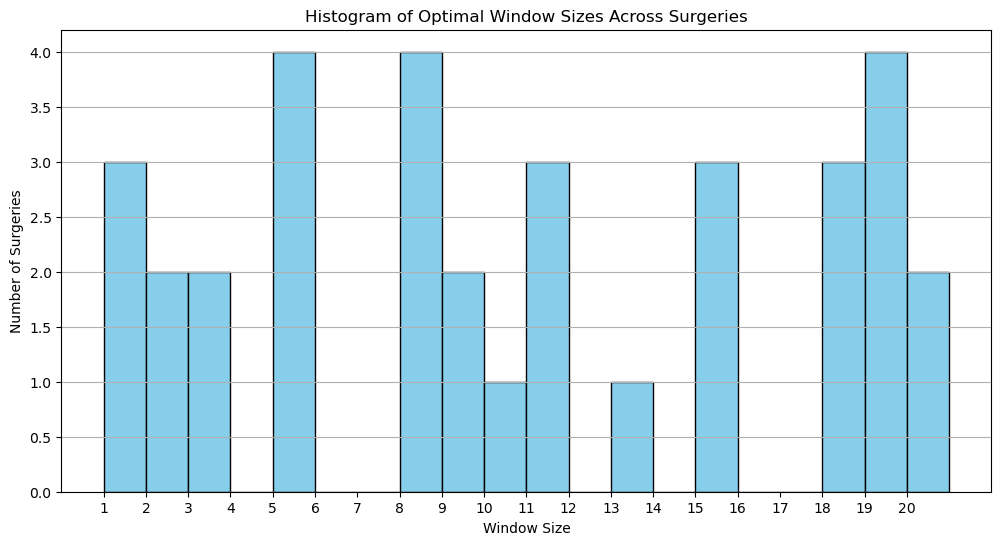

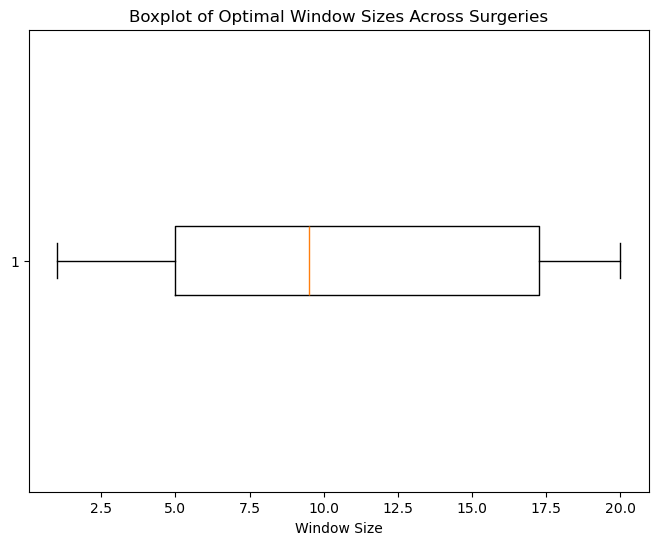

In [ ]:
# --------------------- STEP 6: VISUALIZE THE DISTRIBUTION OF OPTIMAL WINDOW SIZES ---------------------

# Histogram
plt.figure(figsize=(12, 6))
plt.hist(results_df['best_window_size'], bins=range(1, max(results_df['best_window_size']) + 2), color='skyblue', edgecolor='black')
plt.xlabel('Window Size')
plt.ylabel('Number of Surgeries')
plt.title('Histogram of Optimal Window Sizes Across Surgeries')
plt.xticks(range(1, max(results_df['best_window_size']) + 1))
plt.grid(axis='y')
plt.show()

# Boxplot
plt.figure(figsize=(8, 6))
plt.boxplot(results_df['best_window_size'], vert=False)
plt.xlabel('Window Size')
plt.title('Boxplot of Optimal Window Sizes Across Surgeries')
plt.show()

In [16]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.patches import Patch
import random

best_avg_ws = 8

def visualize_surgery_predictions(images_df: pd.DataFrame, models_path: List[Path], dataroot_path: Path, window_size: int = 15):
    """
    Randomly selects a surgery from the validation set and visualizes the predictions from each model,
    ensemble, and smoothed predictions, along with the ground truth.

    The visualization consists of a horizontal bar chart where each row represents:
    - GT (Ground Truth)
    - Each Model's Predictions
    - Ensemble Predictions
    - Prediction Correction

    Each bar segment represents a continuous range of frames with the same predicted task label,
    color-coded accordingly.

    Args:
        images_df (pd.DataFrame): DataFrame containing image information.
        models_path (List[Path]): List of paths to the ensemble models (.pkl files).
        dataroot_path (Path): Path to the data root directory.
        window_size (int): Window size for prediction smoothing.

    Returns:
        None
    """
    # Step 1: Select a random surgery from the validation set
    valid_surgeries = images_df[images_df['valid'] == True]['case_folder'].unique()

    if len(valid_surgeries) == 0:
        raise ValueError("No valid surgeries found in the validation set.")

    random_surgery = random.choice(valid_surgeries)
    print(f'\nSelected Surgery for Visualization: {random_surgery}')

    # Step 2: Filter and sort frames
    try:
        surgery_frames_df = get_sorted_surgery_frames(images_df, random_surgery)
    except ValueError as ve:
        print(f"Error during filtering/sorting: {ve}")
        return

    num_frames = len(surgery_frames_df)
    print(f'Number of frames in {random_surgery}: {num_frames}')

    if num_frames == 0:
        print(f'No frames found for surgery {random_surgery}.')
        return

    # Step 3: Construct full image paths
    image_files = [Path(get_image(r)) for _, r in surgery_frames_df.iterrows()]

    # Verify image existence
    missing_files = [str(img) for img in image_files if not img.exists()]
    if missing_files:
        print(f'Warning: {len(missing_files)} image files are missing for surgery {random_surgery}.')
        # Remove missing files
        image_files = [img for img in image_files if img.exists()]
        surgery_frames_df = surgery_frames_df[surgery_frames_df['filename'].isin([img.stem for img in image_files])]
        print(f'Reduced to {len(image_files)} existing image paths after removing missing files.')

    if not image_files:
        print(f'All image files missing for surgery {random_surgery}.')
        return

    # Step 4: Get ground truth labels
    true_labels = surgery_frames_df['task_label'].tolist()

    # Step 5: Define vocabulary and color mapping
    # Load the first model to get vocab
    first_model_path = models_path[0]
    try:
        first_learner = load_learner(first_model_path, cpu=False)
    except Exception as e:
        print(f"Error loading first model at {first_model_path}: {e}")
        return
    vocab = first_learner.dls.vocab
    del first_learner
    torch.cuda.empty_cache()

    # Define color mapping
    num_classes = len(vocab)
    cmap = plt.get_cmap('tab20')  # Up to 20 distinct colors
    if num_classes > 20:
        cmap = plt.get_cmap('hsv')
    colors = {label: cmap(i % cmap.N) for i, label in enumerate(vocab)}

    # Step 6: Initialize predictions dictionary
    model_predictions = {}
    all_raw_preds = []  # To store raw predictions for ensemble
    model_names = []

    # Step 7: Perform predictions for each model
    for idx, model_path in enumerate(models_path):
        model_name = model_path.stem  # Use the filename without extension
        model_names.append(model_name)
        try:
            learner = load_learner(model_path, cpu=False)
            print(f"Loaded model {model_name} ({idx+1}/{len(models_path)}) from {model_path}.")
        except Exception as e:
            print(f"Error loading model at {model_path}: {e}")
            continue  # Skip models that cannot be loaded

        # Create test_dl with bs=128 and num_workers=8
        test_dl = learner.dls.test_dl(image_files, bs=128, num_workers=8)

        try:
            with torch.no_grad():
                raw_preds, _ = learner.get_preds(dl=test_dl)
            preds = decode_predictions(raw_preds.cpu(), vocab)
            model_predictions[model_name] = preds
            all_raw_preds.append(raw_preds.cpu())
        except Exception as e:
            print(f"Error during prediction with model at {model_path}: {e}")
            continue  # Skip models that cannot predict

        # Clean up
        del learner
        torch.cuda.empty_cache()

    # Check if any predictions were made
    if not all_raw_preds:
        print("No valid predictions were made by any model.")
        return

    # Step 8: Perform ensemble prediction by averaging raw predictions
    print("Performing ensemble prediction by averaging raw predictions.")
    avg_raw_preds = torch.stack(all_raw_preds).mean(0)
    ensemble_pred_labels = decode_predictions(avg_raw_preds, vocab)

    # Step 9: Apply smoothing
    print("Applying smoothing to ensemble predictions.")
    smoothed_pred_labels = smooth_predictions_with_neighbors(ensemble_pred_labels, window_size=window_size)

    # Step 10: Prepare data for plotting
    # Rows: GT, Model1, Model2, ..., Ensemble, Prediction Correction
    rows = ['Ground Truth'] + model_names + ['Ensemble', 'Pred Correction']
    data_rows = []

    # Ground Truth
    data_rows.append(true_labels)

    # Models
    for model_name in model_names:
        data_rows.append(model_predictions[model_name])

    # Ensemble
    data_rows.append(ensemble_pred_labels)

    # Smoothed Predictions
    data_rows.append(smoothed_pred_labels)

    # Step 11: Convert labels to integers for plotting
    label_to_int = {label: idx for idx, label in enumerate(vocab)}
    data_matrix = []
    for row in data_rows:
        row_int = [label_to_int[label] for label in row]
        data_matrix.append(row_int)

    # Convert data_matrix to numpy array
    data_matrix = np.array(data_matrix)

    # Step 12: No blank rows between data rows
    spaced_data_matrix = data_matrix
    spaced_rows = rows

    # Step 13: No need to reverse the data_matrix since GT is already at the top
    # Step 14: Define colormap without 'N/A' and 'blank'
    cmap_colors = [colors[label] for label in vocab]
    cmap_with_missing = ListedColormap(cmap_colors)

    # Define bounds and norm
    bounds = list(range(len(vocab) + 1))  # 0 to len(vocab)
    norm = BoundaryNorm(bounds, cmap_with_missing.N)

    # Step 15: Set font sizes
    plt.rcParams.update({'font.size': 14})

    # Step 16: Create the plot with adjusted figsize to accommodate all frames
    width_per_frame = 0.005  # inches per frame
    desired_width = num_frames * width_per_frame
    min_width = 20  # minimum width in inches
    max_width = 100  # maximum width in inches
    desired_width = max(min_width, desired_width)
    desired_width = min(desired_width, max_width)
    desired_height = len(spaced_rows) * 0.6

    plt.figure(figsize=(desired_width, desired_height))

    # Assign y positions
    y_positions = np.arange(len(spaced_rows))

    # Function to identify segments of consecutive labels
    def get_label_segments(labels):
        segments = []
        if len(labels) == 0:
            return segments
        current_label = labels[0]
        start = 0
        for i in range(1, len(labels)):
            if labels[i] != current_label:
                segments.append((start, i-1, current_label))
                start = i
                current_label = labels[i]
        segments.append((start, len(labels)-1, current_label))
        return segments

    # Step 17: Plot each row using barh
    for i, row in enumerate(spaced_data_matrix):
        y = y_positions[i]
        segments = get_label_segments(row)
        for seg in segments:
            start, end, label_idx = seg
            color = cmap_with_missing.colors[label_idx]
            width = end - start + 1
            bar_height = 0.95  # Adjusted bar height for better visibility
            plt.barh(y, width, left=start, height=bar_height, color=color, edgecolor='none')

    # Step 18: Set y-ticks
    plt.yticks(ticks=y_positions, labels=spaced_rows)

    # Step 19: Set x-ticks at multiples of 100
    x_tick_step = 50
    x_ticks = np.arange(0, num_frames + x_tick_step, x_tick_step)
    plt.xticks(ticks=x_ticks, labels=x_ticks, rotation=90)

    # Step 20: Create custom legend
    legend_elements = [Patch(facecolor=colors[label], edgecolor='k', label=label) for label in vocab]

    # Move legend to the bottom
    plt.legend(handles=legend_elements, bbox_to_anchor=(0.5, -0.15), loc='upper center', borderaxespad=0., ncol=5)

    # Step 21: Adjust the figure layout and legend positioning
    # Increase the bottom margin to make room for the legend and x-axis labels
    plt.subplots_adjust(bottom=0.25)  # Adjust this value as needed (e.g., 0.3 or 0.35)

    # Move legend to the bottom, further away from the plot
    plt.legend(handles=legend_elements, bbox_to_anchor=(0.5, -0.25), loc='upper center', borderaxespad=0., ncol=5)

    # Step 22: Add labels and title
    plt.xlabel('Frame Number')
    plt.title(f'Prediction Visualization for {random_surgery}')

    # Step 23: Save the plot to a file with higher DPI for better clarity
    output_path = Path(f"{random_surgery}_prediction_visualization.png")
    plt.savefig(output_path, dpi=600, bbox_inches='tight')
    print(f"Visualization saved to {output_path}")

    # Step 24: Display the plot
    plt.show()


Selected Surgery for Visualization: case_129
Number of frames in case_129: 2181
Loaded model regnety_008 (1/3) from models/baseline/regnety_008.pkl.


Loaded model convnextv2_tiny (2/3) from models/baseline/convnextv2_tiny.pkl.


Loaded model vit_tiny (3/3) from models/baseline/vit_tiny.pkl.


Performing ensemble prediction by averaging raw predictions.
Applying smoothing to ensemble predictions.
Visualization saved to case_129_prediction_visualization.png


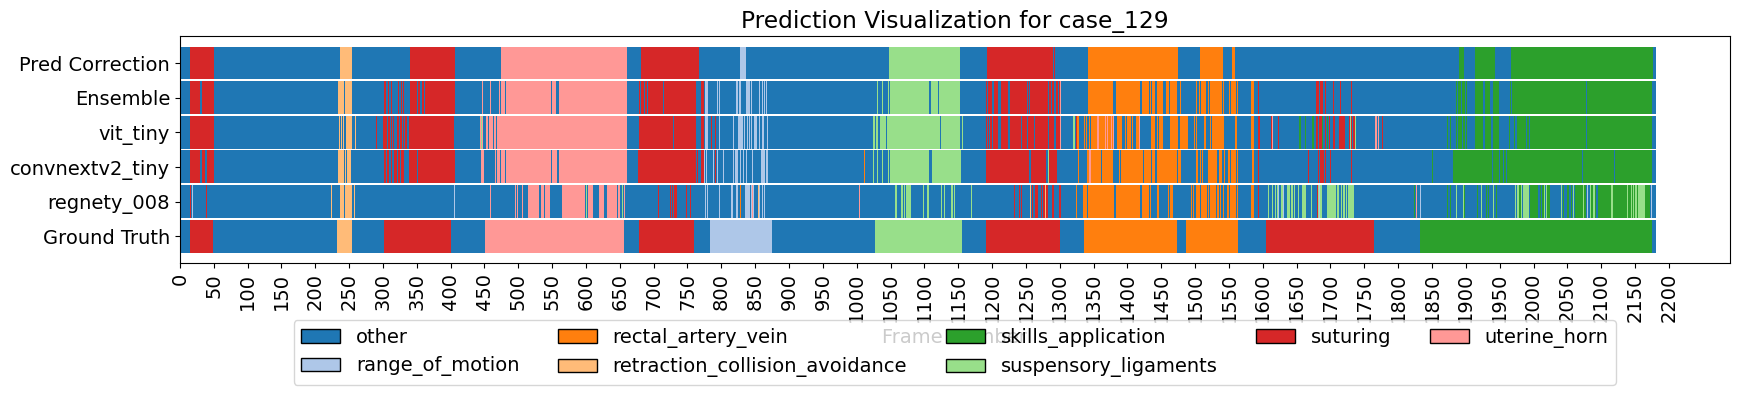

In [17]:
visualize_surgery_predictions(images_df, models_path, dataroot_path, window_size=best_avg_ws)